### About 

"""
#++++++++++++++++++++++++++++++++++++++++++++++

    Project: Part of final project for Georgia Tech Institute of Technology course DL, CS 7643. 

    Totality of this code is non-proprietary and may be used at will. 

#++++++++++++++++++++++++++++++++++++++++++++++


Description: 

@brief a notebook defining steps for loading a model checkpoint and running evaluation (test) on this model, along with plotting training/val curves.

@author: Greg Zdor (gzdor@icloud.com)

@date Date_Of_Creation: 4/17/2023 

@date Last_Modification 4/17/2023 

No Copyright - use at will

"""

### Imports

In [1]:
# Imports 

# System level imports 
import os 
import sys
import time 
import tqdm
import yaml
from datetime import datetime

# DL imports 
import torch
import torchinfo
import torchmetrics
import torchsummary
import torch.nn as nn
import pytorch_lightning as pl

# Data science imports 
import numpy as np
import pandas as pd 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Visualization packages 
import matplotlib.pyplot as plt 
from matplotlib.ticker import  MultipleLocator

# Add local source files to namespace 
sys.path.append(f'..{os.sep}..{os.sep}')

# Local imports
from pkgs.ml.neural_net_search_spaces import (
    lightning_vanilla_cnn_classifier_cfg,
    lightning_tunable_cnn_classifier_cfg,
)

from pkgs.ml.model_evaluation_analysis import model_evaluation
from pkgs.ml.neural_net_definitions import LightningCNNClassifier
from pkgs.dataset.oracle_lightning_dataset import LightningOracleDataset

from pkgs.dataset.memory_mapper import load_parameters, SigMFDataMMapper
from pkgs.dataset.sigmf_dataset import SigMFDataset, IQDataAugmenter

now = datetime.now()
print(f'\n\nLast time this cell was run was \n\n  {now.strftime("%d/%m/%Y %H:%M:%S")}\n\n')



Last time this cell was run was 

  17/04/2023 22:50:01




In [2]:
start_dir = os.getcwd() 
os.chdir(f'..{os.sep}..{os.sep}..{os.sep}')
repo_root_path = os.getcwd() 
os.chdir(start_dir)

print(f'\n Repo location of:   {repo_root_path}')


 Repo location of:   /MLSR_Shared_Folder/gzdor/cs7643_pytorch/rf_fingerprinting_project/Radio_Frequency_Fingerprinting_802.11


### Test data & model checkpoint settings - user update these

In [3]:
test_dataset_yaml = "memory_mapper.yml"

# checkpoint_path = r"experiment_2023_04_17_12_08_43_08S/version_0/checkpoints/epoch=4-step=19540.ckpt"
checkpoint_path = r"experiment_2023_04_17_15_08_14_08S/version_0/checkpoints/epoch=23-step=93792.ckpt"


#TODO - create dataset mem mapper YAML with all ranges 

checkpoint_path = os.path.join(repo_root_path, "src", "tools", "ml_train", "lightning_logs", checkpoint_path)
if not os.path.isfile(checkpoint_path):
    print(f'\n\nCurrent checkpoint file path does not exist, check path. \n\n {checkpoint_path} \n\n')

# Load dataset configuration YAML
dataset_config_path = os.path.join(repo_root_path, "src", "pkgs", "dataset", test_dataset_yaml)
with open(dataset_config_path, "rt") as h_file:
    dataset_parameters = yaml.safe_load(h_file)
    
# Create dataset object 
lightning_test_dataset = LightningOracleDataset(dataset_parameters)


memmap base path: self.mmap_dir:  /MLSR_Shared_Folder/gzdor/cs7643_pytorch/rf_fingerprinting_project/data/MemMapData

Using 6 workers for data loading in current Lightning data module.



### Load model from checkpoint

In [4]:

def weights_update(model, checkpoint):
    # workaround to lightning model with inputs bug:  # https://github.com/Lightning-AI/lightning/issues/924    
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model


# Get model configuration parameters 
model_params = lightning_vanilla_cnn_classifier_cfg()

model = weights_update(model = LightningCNNClassifier(model_params), checkpoint=torch.load(checkpoint_path))

# View model 
torchsummary.summary(model.cuda(), (2, 128))

# Set model in evaluation mode (turns off drop out, etc)
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 256, 128]           1,792
       BatchNorm1d-2             [-1, 256, 128]             512
              ReLU-3             [-1, 256, 128]               0
         MaxPool1d-4             [-1, 256, 127]               0
            Conv1d-5             [-1, 128, 127]          98,432
       BatchNorm1d-6             [-1, 128, 127]             256
              ReLU-7             [-1, 128, 127]               0
            Conv1d-8             [-1, 128, 127]          49,280
       BatchNorm1d-9             [-1, 128, 127]             256
             ReLU-10             [-1, 128, 127]               0
           Conv1d-11             [-1, 128, 127]          49,280
      BatchNorm1d-12             [-1, 128, 127]             256
             ReLU-13             [-1, 128, 127]               0
    ResidualBlock-14             [-1, 1

LightningCNNClassifier(
  (residual_block1): ResidualBlock(
    (conv1): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (residual_block2): ResidualBlock(
    (conv1): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (conv_1): Conv1d(2, 256, kernel_size

### Run test via Lightning data module test method

In [5]:
# Test model 

# Define test pl.Trainer() 
test_trainer = pl.Trainer(enable_checkpointing=False, logger=False, devices = 1) 

t_start = time.time()

test_trainer.test(model, lightning_test_dataset)

train_time_seconds = time.time() - t_start

print(f'\n\nTotal test time was:   {time.time() - t_start}.\n')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 977/977 [00:16<00:00, 58.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      avg_test_acc          0.1941828578710556
      avg_test_loss          9.901749610900879
      test_accuracy         0.19420085847377777
        test_loss            9.901779174804688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Total test time was:   17.930589199066162.



### Plot accuracy, loss curves off of training/validation logs data

In [6]:
def color_legend_texts(leg):
    """Color legend texts based on color of corresponding lines"""
    for line, txt in zip(leg.get_lines(), leg.get_texts()):
        txt.set_color(line.get_color())  

In [7]:
# Get training loss and accuracy history data 

current_lightning_logs_path = os.path.dirname(os.path.dirname(checkpoint_path))

current_logs_csv = os.path.join(os.getcwd(), current_lightning_logs_path, "metrics.csv")

if not os.path.isfile(current_logs_csv):
    print(f'\n\nCurrent metrics.csv file path does not exist, check path. \n\n {current_logs_csv} \n\n')

In [8]:
df = pd.read_csv(current_logs_csv)

df.head()

# Note - the NaN values in ths dataframe are because it logs train acc/loss every n steps within an epoch, 
# but logs other metrics less frequently, so it assigns NaNs as placeholders 

,train_loss,train_accuracy,epoch,step,validation_loss,validation_accuracy,avg_val_acc,avg_val_loss,avg_tr_acc,avg_tr_loss
0,2.786910,0.075195,0,49,NaN,NaN,NaN,NaN,NaN,NaN
1,2.768476,0.084961,0,99,NaN,NaN,NaN,NaN,NaN,NaN
2,2.743370,0.078125,0,149,NaN,NaN,NaN,NaN,NaN,NaN
3,2.686273,0.116211,0,199,NaN,NaN,NaN,NaN,NaN,NaN
4,2.630010,0.135742,0,249,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
tr_acc = df[df['avg_tr_acc'].notnull()]['avg_tr_acc']
val_acc = df[df['avg_val_acc'].notnull()]['avg_val_acc']

tr_loss = df[df['avg_tr_loss'].notnull()]['avg_tr_loss']
val_loss = df[df['avg_val_loss'].notnull()]['avg_val_loss']

# Get number of epochs this model was trained for 
n_epochs = len(tr_loss)

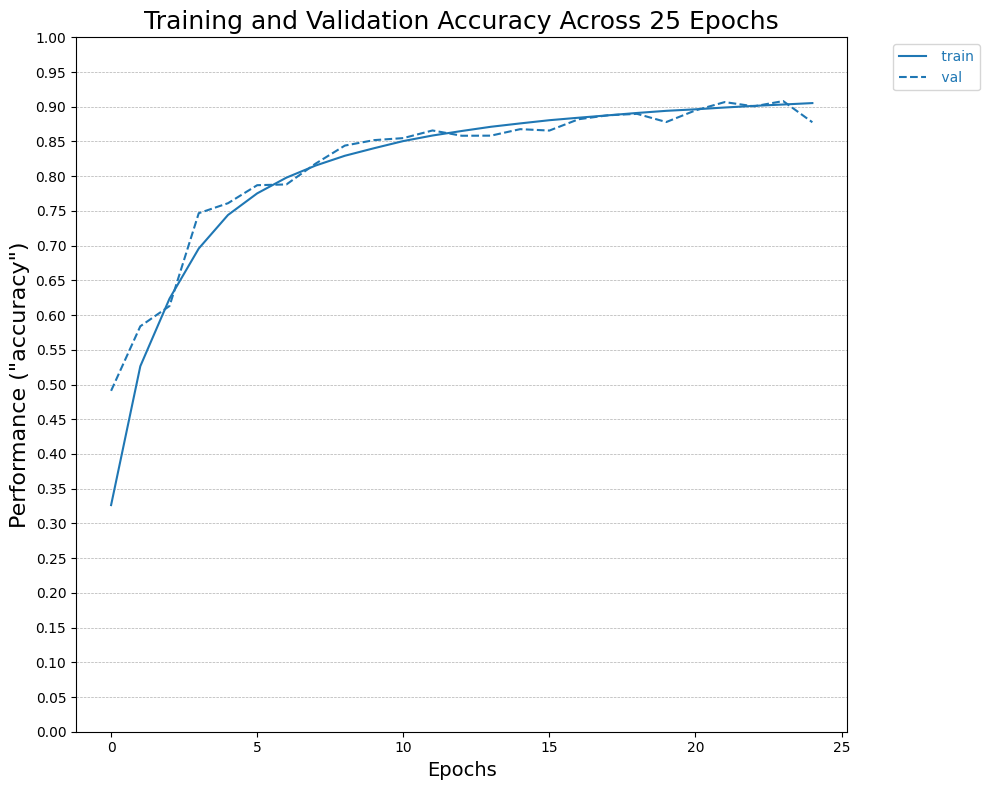

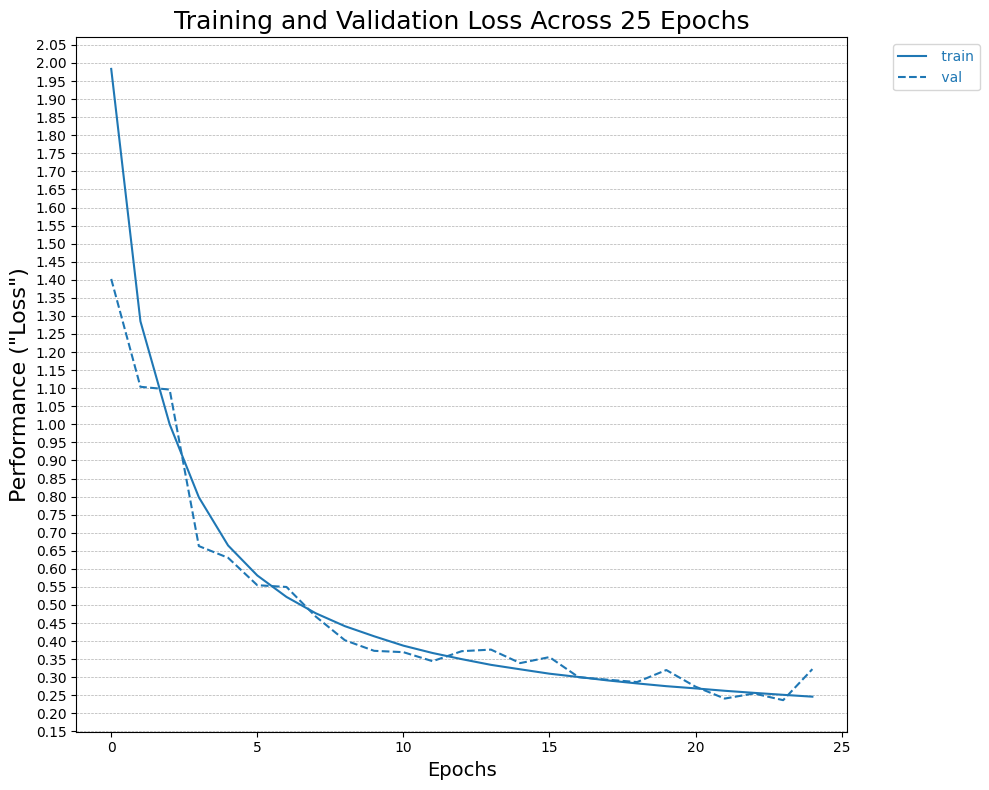

In [10]:
# Display train/validate accuracy and loss curves 

# Accuracy curves 
%matplotlib inline  
plt.figure(figsize=(10,8))
plt.title(f'Training and Validation Accuracy Across {n_epochs} Epochs', fontsize = 18)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel(f'Performance ("accuracy")', fontsize = 16)
ax = plt.gca()

color = next(ax._get_lines.prop_cycler)['color']
plt.plot(range(len(val_loss)), tr_acc, label = ' train', color = color)
plt.plot(range(len(val_loss)), val_acc, '--', label = ' val', color = color)

legend = plt.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left')

ax = plt.gca()
ax.set_ylim([0, 1])
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_locator(MultipleLocator(0.05))
color_legend_texts(legend)
plt.tight_layout()


# Loss curves
plt.figure(figsize=(10,8))
plt.title(f'Training and Validation Loss Across {n_epochs} Epochs', fontsize = 18)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel(f'Performance ("Loss")', fontsize = 16)
ax = plt.gca()

color = next(ax._get_lines.prop_cycler)['color']
plt.plot(range(len(val_loss)), tr_loss, label = ' train', color = color)
plt.plot(range(len(val_loss)), val_loss, '--', label = ' val', color = color)

legend = plt.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left')

ax = plt.gca()
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_locator(MultipleLocator(0.05))
color_legend_texts(legend)
plt.tight_layout()

plt.show()

### Show training/val accuracy/loss curves across steps, not just epochs 

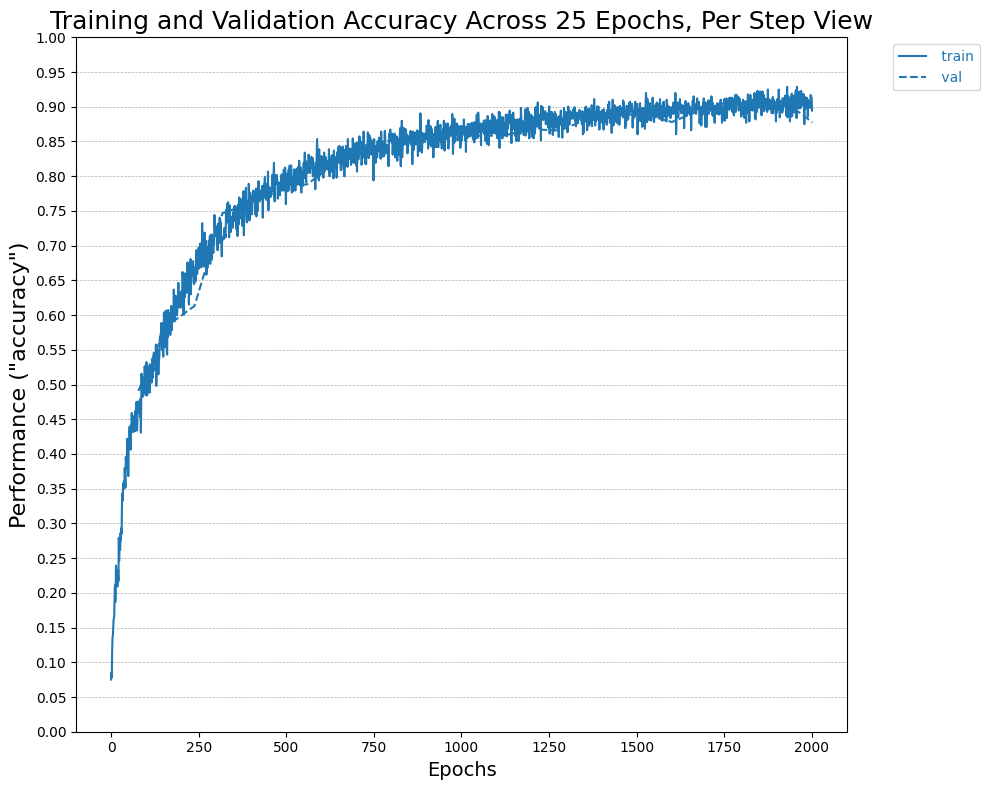

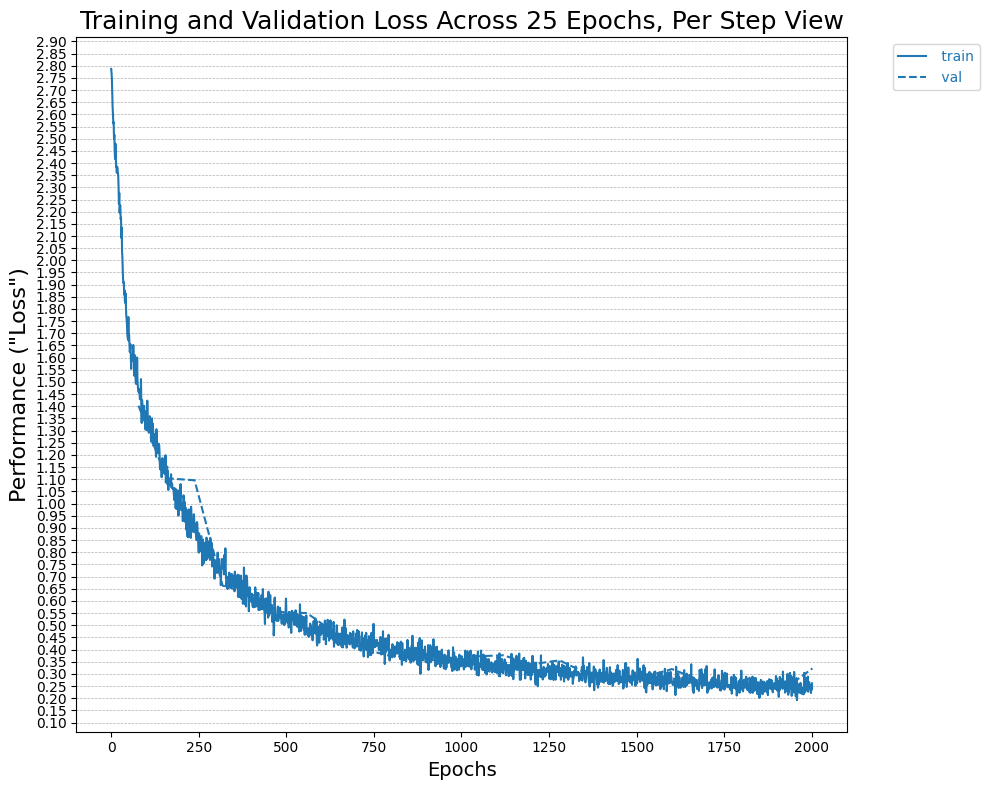

In [11]:
tr_acc = df[df['train_accuracy'].notnull()]['train_accuracy']
val_acc = df[df['validation_accuracy'].notnull()]['validation_accuracy']

tr_loss = df[df['train_loss'].notnull()]['train_loss']
val_loss = df[df['validation_loss'].notnull()]['validation_loss']

# Display train/validate accuracy and loss curves 

# Accuracy curves 
%matplotlib inline  
plt.figure(figsize=(10,8))
plt.title(f'Training and Validation Accuracy Across {n_epochs} Epochs, Per Step View', fontsize = 18)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel(f'Performance ("accuracy")', fontsize = 16)
ax = plt.gca()

color = next(ax._get_lines.prop_cycler)['color']
plt.plot( tr_acc, label = ' train', color = color)
plt.plot(val_acc, '--', label = ' val', color = color)

legend = plt.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left')

ax = plt.gca()
ax.set_ylim([0, 1])
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_locator(MultipleLocator(0.05))
color_legend_texts(legend)
plt.tight_layout()


# Loss curves
plt.figure(figsize=(10,8))
plt.title(f'Training and Validation Loss Across {n_epochs} Epochs, Per Step View', fontsize = 18)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel(f'Performance ("Loss")', fontsize = 16)
ax = plt.gca()

color = next(ax._get_lines.prop_cycler)['color']
plt.plot(tr_loss, label = ' train', color = color)
plt.plot(val_loss, '--', label = ' val', color = color)

legend = plt.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left')

ax = plt.gca()
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.yaxis.set_major_locator(MultipleLocator(0.05))
color_legend_texts(legend)
plt.tight_layout()

plt.show()

### Get max average validation accuracy

In [12]:
overall_avg_acc = max(df[df['avg_val_acc'].notnull()]['avg_val_acc'])

print(f'\nOverall average validation accuracy is {str(overall_avg_acc*100)} % \n\n')


Overall average validation accuracy is 90.82126617431639 % 




### Make per-class predictions manually

In [6]:
### Get per-class accuracies

memmapper = SigMFDataMMapper(dataset_parameters)
manually_defined_test_set = SigMFDataset("test", memmapper, transform = None)

print(f'\nNumber of 128-len sequences in this test set:  {manually_defined_test_set.h_labels.size}\n')


memmap base path: self.mmap_dir:  /MLSR_Shared_Folder/gzdor/cs7643_pytorch/rf_fingerprinting_project/data/MemMapData

Number of 128-len sequences in this test set:  1000320



In [14]:
# curr_sequence = np.vstack((manually_defined_test_set[0][0][0], manually_defined_test_set[0][0][1]))
# curr_sequence = torch.from_numpy(curr_sequence).float() # .to(device = 1)

curr_sequence = manually_defined_test_set[0][0]
curr_sequence = torch.unsqueeze(curr_sequence, dim = 0)

curr_label = manually_defined_test_set[0][1][0]

# Make forward pass and get softmax probabilities
curr_prediction = model(curr_sequence)
curr_prediction = model.get_softmax(curr_prediction)

# Get predicted class index
curr_prediction_idx = torch.argmax(curr_prediction)

print(
    f'True class is:           {curr_label}\n'
    f'Predicted class is       {curr_prediction_idx}\n'
    f'\n\nPredicted probabilties\n\n   {curr_prediction}'
)

True class is:           11
Predicted class is       15


Predicted probabilties

   tensor([[1.3807e-12, 1.4918e-02, 1.3272e-02, 5.6270e-10, 7.6786e-04, 1.8102e-04,
         2.2225e-07, 4.8715e-06, 3.6869e-06, 9.5395e-05, 1.2109e-04, 7.1559e-08,
         2.2981e-08, 1.0897e-07, 3.8609e-11, 9.7064e-01]],
       grad_fn=<SoftmaxBackward0>)


In [7]:
# Run predictions on all samples in test dataset 
prediction_idxs = [] 
prediction_probabilities = []
label_idxs = []

batch_size = 512

# Move model to GPU 
model.to(device = 1)

n_samples = manually_defined_test_set.h_labels.size
n_batches = int(np.ceil(n_samples/batch_size))
last_batch_size = n_batches*batch_size - n_samples

for batch_idx in tqdm.tqdm(range(n_batches)): 
    
    sample_start_idx = batch_idx*batch_size
    sample_stop_idx = sample_start_idx + batch_size
    
    if batch_idx == n_batches-1:
        sample_stop_idx = sample_start_idx + last_batch_size
        
    curr_sequence = manually_defined_test_set[sample_start_idx : sample_stop_idx][0].to(device = 1)
    
    curr_labels = manually_defined_test_set[sample_start_idx : sample_stop_idx][1]
    
    # Make forward pass and get softmax probabilities
    curr_prediction = model(curr_sequence)
    curr_prediction = model.get_softmax(curr_prediction)

    # Get predicted class index
    curr_prediction_idxs = torch.argmax(curr_prediction, dim = 1)
    
    # Save predictions and labels 
    label_idxs.append(curr_labels)
    prediction_idxs.append(curr_prediction_idxs)
    prediction_probabilities.append(curr_prediction.detach().cpu().numpy())

100%|██████████| 1954/1954 [00:15<00:00, 128.34it/s]


In [ ]:
# Format predicted and label indices tensors 

label_idxs_tmp = torch.stack(label_idxs[0:-2])
label_idxs_tmp.squeeze()
label_idxs_tmp = torch.reshape(label_idxs_tmp, (-1,))
last_batch_results = label_idxs[-1].squeeze()
label_idxs_1d = torch.cat((label_idxs_tmp, last_batch_results))

prediction_idxs_tmp = torch.stack(prediction_idxs[0:-2])
prediction_idxs_tmp.squeeze()
prediction_idxs_tmp = torch.reshape(prediction_idxs_tmp, (-1,))
last_batch_results = prediction_idxs[-1]
prediction_idxs_1d = torch.cat((prediction_idxs_tmp, last_batch_results))

#TODO - format prediction_probabilities

In [ ]:
# Convert to arrays 
labels_idxs_arr      = label_idxs_1d.detach().cpu().numpy()
predictions_idxs_arr = prediction_idxs_1d.detach().cpu().numpy()

### Get confusion matrix

In [ ]:
labels_idxs_arr[0:26]

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11])

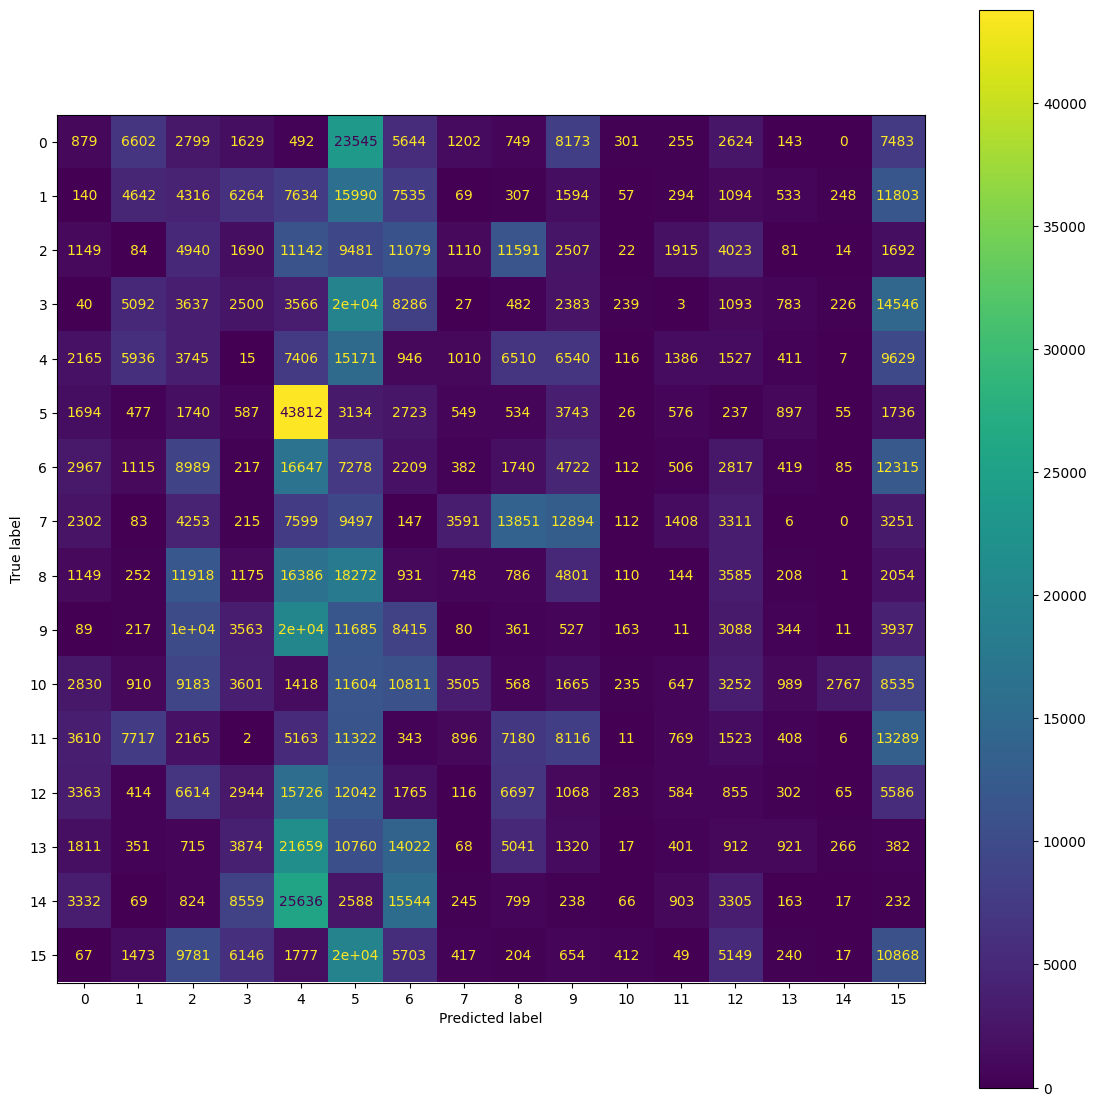

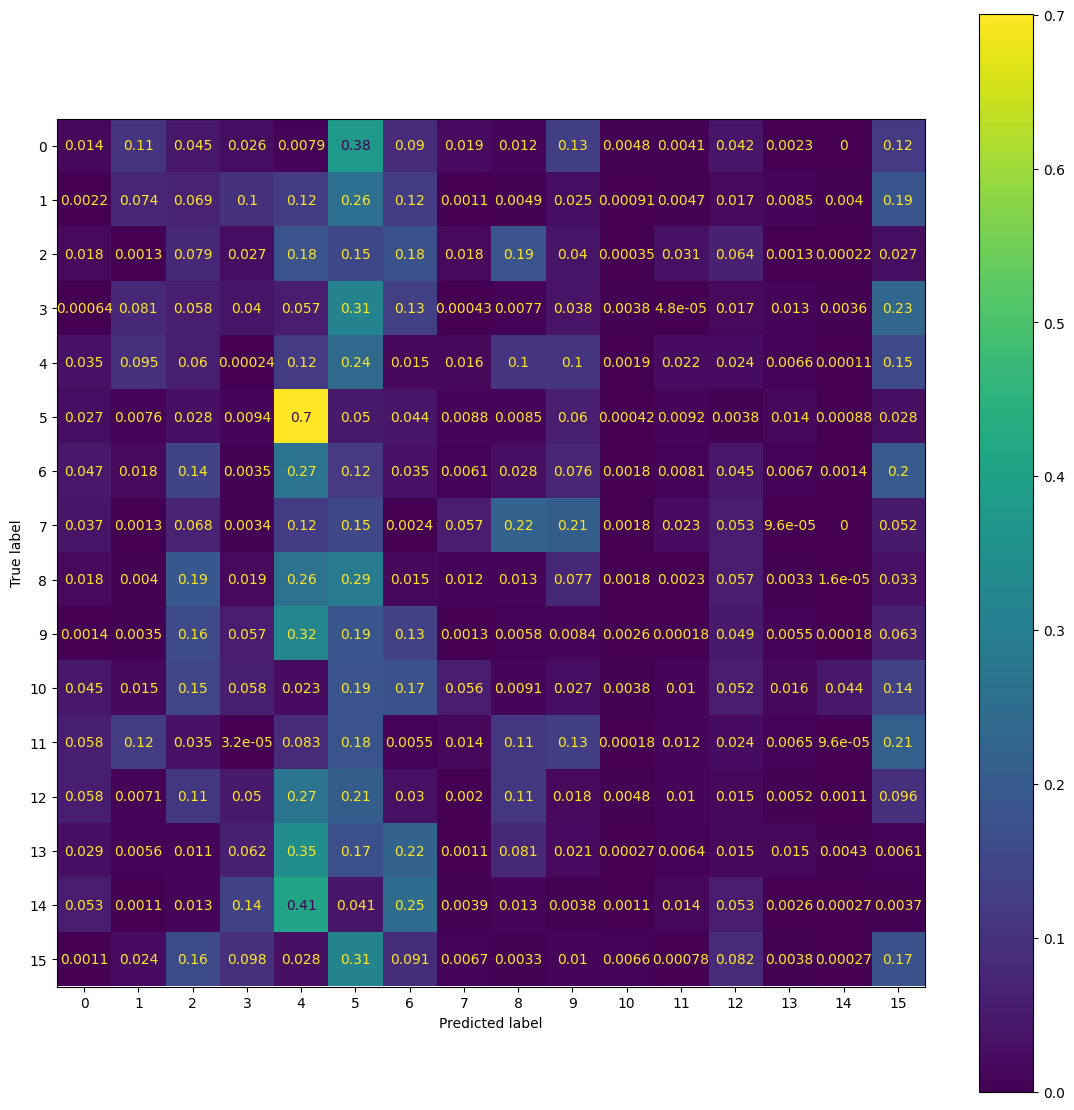

In [ ]:
# Create  confusion matrix

# Unnormalized 
confusion_matx = confusion_matrix(list(labels_idxs_arr), list(predictions_idxs_arr))

confusion_matrix_view = ConfusionMatrixDisplay(confusion_matrix = confusion_matx, display_labels=np.arange(16))

fig, ax = plt.subplots(figsize=(14,14))
confusion_matrix_view.plot(ax = ax)

# Normalized 
confusion_matx = confusion_matrix(list(labels_idxs_arr), list(predictions_idxs_arr), normalize = 'true')

confusion_matrix_view = ConfusionMatrixDisplay(confusion_matrix = confusion_matx, display_labels=np.arange(16))

fig, ax = plt.subplots(figsize=(14,14))
confusion_matrix_view.plot(ax = ax)


plt.show()

In [ ]:
### Get per-class accuracies

print(classification_report(list(labels_idxs_arr), list(predictions_idxs_arr)))

              precision    recall  f1-score   support

           0       0.03      0.01      0.02     62520
           1       0.13      0.07      0.09     62520
           2       0.06      0.08      0.07     62520
           3       0.06      0.04      0.05     62520
           4       0.04      0.12      0.06     62520
           5       0.02      0.05      0.02     62520
           6       0.02      0.04      0.03     62520
           7       0.26      0.06      0.09     62520
           8       0.01      0.01      0.01     62520
           9       0.01      0.01      0.01     62520
          10       0.10      0.00      0.01     62520
          11       0.08      0.01      0.02     62520
          12       0.02      0.01      0.02     58424
          13       0.13      0.01      0.03     62520
          14       0.00      0.00      0.00     62520
          15       0.10      0.17      0.13     62520

    accuracy                           0.04    996224
   macro avg       0.07   

### Get Receiver Operator Characteristic (ROC) curve 

In [8]:
# Create ROC curve 

# all imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


def plot_roc_curve(y_test, y_pred):
    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    #plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curve")
    plt.legend()
    
# plot_roc_curve(labels_idxs_arr, predictions_idxs_arr)